In [1]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "4"
os.environ["NUM_THREADS"] = "4"
os.environ["OMP_NUM_THREADS"] = "4"
from keras.layers import Input, Dense, Flatten, Reshape
from sklearn.feature_extraction import image as sk_image
from concurrent.futures import ProcessPoolExecutor
import cartopy.feature as cfeature
from keras.models import Model
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from sklearn.cluster import AgglomerativeClustering
from scipy.signal import convolve2d 
from scipy import ndimage
from sklearn.cluster import KMeans
import numpy as np
import tensorflow as tf
from tensorflow import keras    
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from sklearn.cluster import DBSCAN
from pyhdf.SD import SD, SDC
import matplotlib as mpl
#tf.config.threading.set_inter_op_parallelism_threads(1)
from extract_training_data import *
from sklearn.feature_extraction.image import extract_patches_2d, reconstruct_from_patches_2d
from pyhdf.error import HDF4Error
from functions import *
from tensorflow.keras.models import load_model
from sklearn.cluster import KMeans, MiniBatchKMeans
import joblib
import plot_functions
import importlib 
importlib.reload(plot_functions)
from plot_functions import *
from sklearn.model_selection import train_test_split
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping
from write_to_tf import * 
# Visualize the result

total cores: 256
1 Physical GPUs, 1 Logical GPUs


2023-12-20 16:24:12.936629: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 19960 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:25:00.0, compute capability: 7.5


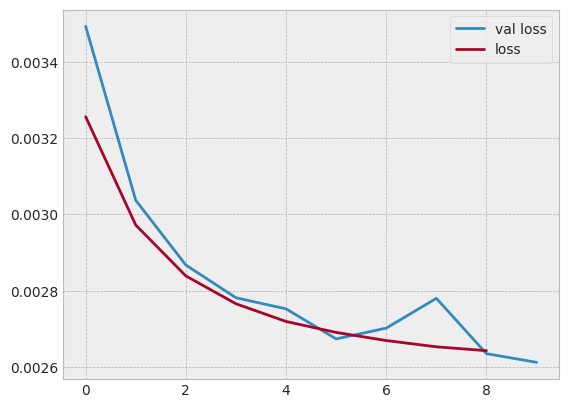

In [12]:
import pickle

with open('/uio/hume/student-u37/fslippe/data/models/patch_size128/filter32/training_history_dnb_l95_z50_ps128_f32_201812-202312.pkl', 'rb') as f:
    loaded_history_2 = pickle.load(f)

plt.plot(loaded_history_1["val_loss"], label="val loss")
plt.plot(loaded_history_1["loss"][1:], label="loss")
plt.legend()


In [29]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,"  , len(logical_gpus), "Logical GPUs")
        tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

import socket
hostname = socket.gethostname()
if "nird" in hostname:
    tf.config.threading.set_inter_op_parallelism_threads(8)
    data_loc = "/nird/projects/NS9600K/fslippe/data/"
    folder = "/nird/projects/NS9600K/data/modis/cao/MOD02/2020/ /nird/projects/NS9600K/data/modis/cao/MOD02/2021/ /nird/projects/NS9600K/data/modis/cao/MOD02/2023/"
if "mimi" in hostname:
    data_loc = "/uio/hume/student-u37/fslippe/data/"
    folder = "/scratch/fslippe/modis/MOD02/2019/ /scratch/fslippe/modis/MOD02/2020/ /scratch/fslippe/modis/MOD02/2021/ /scratch/fslippe/modis/MOD02/2022/ /scratch/fslippe/modis/MOD02/2023/ /scratch/fslippe/modis/MOD02/daytime_1km/ /scratch/fslippe/modis/MOD02/boundary_1km/ /scratch/fslippe/modis/MOD02/night_1km/ /scratch/fslippe/modis/MOD02/may-nov_2021/ /scratch/fslippe/modis/MOD02/cao_test_data/"


bands=[29]
#max_vals = np.load("%smodels/max_vals_dnb_l95_z50_ps128_(29)_cao_months_202012-202111.npy" %data_loc)
from autoencoder import SobelFilterLayer, SimpleAutoencoder
print(len(bands))

#encoder = load_model("/uio/hume/student-u37/fslippe/data/models/winter_2020_21_band(6,20,29)_encoder")

1 Physical GPUs, 1 Logical GPUs
1


In [33]:
# Load training data 
patch_size = 64
model_run_name = "dnb_l95_z50_ps%s_band29" %(patch_size)
years = [2018, 2019, 2020, 2021, 2022, 2023]
train_data = []
test_data = []

for year in years:
    train_data.append(np.load("/scratch/fslippe/modis/MOD02/training_data/patch_size_%s/train_%s_%s.npy" %(patch_size, model_run_name, year)))
    test_data.append(np.load("/scratch/fslippe/modis/MOD02/training_data/patch_size_%s/test_%s_%s.npy" %(patch_size, model_run_name, year)))


# Combine all
combined_train_data = np.concatenate((train_data), axis=0)
combined_test_data = np.concatenate((test_data), axis=0)
max_val = np.max(combined_train_data)
min_val = np.min(combined_train_data) 
print("number of patches:", len(combined_train_data))
print("mean:", np.mean(combined_train_data))
print("max:", max_val)
print("min:", min_val)
normlized_train_data = (combined_train_data - min_val) / (max_val - min_val)
normlized_test_data = (combined_test_data - min_val) / (max_val - min_val)


number of patches: 2626403
mean: 3.823714
max: 9.665925
min: 0.53430617


In [34]:
model_folder_save = f"/uio/hume/student-u37/fslippe/data/models/patch_size{patch_size}/"
model_tfdata_save = f"/scratch/fslippe/modis/MOD02/training_data/tf_data/{model_run_name}/"

os.makedirs(model_folder_save, exist_ok=True)
os.makedirs(model_tfdata_save, exist_ok=True)

np.save(model_folder_save + "max_val_%s" %(model_run_name) +"_2018-2023", max_val)
np.save(model_folder_save + "min_val_%s" %(model_run_name) +"_2018-2023", min_val)
np.save(model_tfdata_save + "normalized_valpatches_%s" %(model_run_name), normlized_test_data)




In [39]:
patches_per_file = int(50000 * (128/patch_size)**2)
patches_per_file

200000

In [40]:
patches_per_file = int(50000 * (128/patch_size)**2)
tot_files = int(len(combined_train_data) / patches_per_file)

for i in range(tot_files):
    if i < tot_files-1:
        chunk = normlized_train_data[i*patches_per_file: i*patches_per_file+patches_per_file]
    else:
        chunk = normlized_train_data[i*patches_per_file: ]
    print(i, len(chunk))
    print(f"{model_tfdata_save}_{i}.tfrecord")
    write_tfrecord(model_tfdata_save + f"normalized_trainingpatches_{model_run_name}_{i}.tfrecord", chunk)


0 200000
/scratch/fslippe/modis/MOD02/training_data/tf_data/dnb_l95_z50_ps64_band29/_0.tfrecord
1 200000
/scratch/fslippe/modis/MOD02/training_data/tf_data/dnb_l95_z50_ps64_band29/_1.tfrecord
2 200000
/scratch/fslippe/modis/MOD02/training_data/tf_data/dnb_l95_z50_ps64_band29/_2.tfrecord
3 200000
/scratch/fslippe/modis/MOD02/training_data/tf_data/dnb_l95_z50_ps64_band29/_3.tfrecord
4 200000
/scratch/fslippe/modis/MOD02/training_data/tf_data/dnb_l95_z50_ps64_band29/_4.tfrecord
5 200000
/scratch/fslippe/modis/MOD02/training_data/tf_data/dnb_l95_z50_ps64_band29/_5.tfrecord
6 200000
/scratch/fslippe/modis/MOD02/training_data/tf_data/dnb_l95_z50_ps64_band29/_6.tfrecord
7 200000
/scratch/fslippe/modis/MOD02/training_data/tf_data/dnb_l95_z50_ps64_band29/_7.tfrecord
8 200000
/scratch/fslippe/modis/MOD02/training_data/tf_data/dnb_l95_z50_ps64_band29/_8.tfrecord
9 200000
/scratch/fslippe/modis/MOD02/training_data/tf_data/dnb_l95_z50_ps64_band29/_9.tfrecord
10 200000
/scratch/fslippe/modis/MOD02/t